# 🗼 UofU Flux Towers

> Demonstrates the following:
>
> - Getting timeseries data
> - Plotting with Seaborn
> - Dealing with stations with multiple sensors measuring the same variable

I like to keep tabs on what my grad school research group is up to. It looks like they recently installed two eddy-covariance flux measurement sites around the Great Salt Lake. [Blog: UUPYF tower deployment](https://horelresearch.blogspot.com/2024/09/26-september-2024-uupyf-tower-deployment.html) 

- [UUPYF](https://mesowest.utah.edu/cgi-bin/droman/meso_base_dyn.cgi?stn=uupyf): Playa Flux Tower
- [UUCMF](https://mesowest.utah.edu/cgi-bin/droman/meso_base_dyn.cgi?stn=uucmf): UofU Compass Minerals Flux Tower



I wanted to check that SynopticPy can parse and plot this data!

I don't know anything about these two sites, so this notebook will be a bit of exploration on my part.

I can see in the MesoWest pages linked above that temperature and humidity are measured twice at 2.3 meters--EC150 and LI710...whatever that means. I asked ChatGPT and it gave a nice answer

> EC150: Refers to a specific model of gas analyzer or eddy covariance system, such as the Campbell Scientific EC150.
>
> LI710: Refers to the LI-COR LI-710, which is a high-precision gas analyzer used for atmospheric measurements.

Ok, I get it now. These are just two instruments measuring temperature and humidity.

I confirmed this in the station info pages for [UUCMF](https://mesowest.utah.edu/cgi-bin/droman/station_total.cgi?stn=UUCMF&unit=0) and [UUPYF](https://mesowest.utah.edu/cgi-bin/droman/station_total.cgi?stn=UUPYF&unit=0).



In [40]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from herbie.toolbox import EasyMap

import synoptic

Where are these stations located? Near the Great Salt Lake 

> Note: the GSL is not currently filled as high as the plot shows.

🚚💨 Speedy delivery from Synoptic's metadata service.
📦 Received data from 3 stations (0.20 seconds).


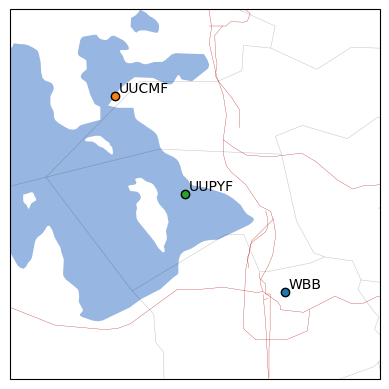

In [8]:
metadata = synoptic.Metadata(stid=["UUCMF", "UUPYF", "WBB"]).df()

ax = EasyMap("10m").LAKES().ROADS().COUNTIES().ax

for i in metadata.iter_rows(named=True):
    ax.scatter(i["longitude"], i["latitude"], zorder=100, ec="k")
    ax.text(i["longitude"] + 0.01, i["latitude"] + 0.01, i["stid"], zorder=100)


ax.set_extent(
    [
        metadata["longitude"].mean() - 0.5,
        metadata["longitude"].mean() + 0.5,
        metadata["latitude"].mean() - 0.5,
        metadata["latitude"].mean() + 0.5,
    ]
)

Let's get the last 5 days of data from these two stations...

In [23]:
s = synoptic.TimeSeries(recent=timedelta(days=5), stid=["UUCMF", "UUPYF"])
df = s.df()

df.head(3)

🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 2 stations (0.32 seconds).


stid,date_time,variable,sensor_index,is_derived,value,value_sting,units,id,name,elevation,latitude,longitude,mnet_id,state,timezone,elev_dem,period_of_record_start,period_of_record_end,qc_flagged,is_restricted,restricted_metadata,is_active
str,"datetime[μs, UTC]",str,u32,bool,f64,str,str,u32,str,f64,f64,f64,u32,str,str,f64,"datetime[μs, UTC]","datetime[μs, UTC]",bool,bool,bool,bool
"""UUCMF""",2024-12-14 05:30:00 UTC,"""pressure""",1,false,87744.0,null,"""Pascals""",243225,"""UofU Compass Minerals Flux Tow…",4205.0,41.29614,-112.30739,153,"""UT""","""America/Denver""",null,2024-08-16 13:00:00 UTC,2024-12-19 04:30:00 UTC,false,false,false,true
"""UUCMF""",2024-12-14 06:00:00 UTC,"""pressure""",1,false,87749.0,null,"""Pascals""",243225,"""UofU Compass Minerals Flux Tow…",4205.0,41.29614,-112.30739,153,"""UT""","""America/Denver""",null,2024-08-16 13:00:00 UTC,2024-12-19 04:30:00 UTC,false,false,false,true
"""UUCMF""",2024-12-14 06:30:00 UTC,"""pressure""",1,false,87734.0,null,"""Pascals""",243225,"""UofU Compass Minerals Flux Tow…",4205.0,41.29614,-112.30739,153,"""UT""","""America/Denver""",null,2024-08-16 13:00:00 UTC,2024-12-19 04:30:00 UTC,false,false,false,true


First off, remember these stations measure some variables twice, which is indicated by the "sensor index". This is important to know. I'm using Seaborn to make my plots.

In [24]:
df.select("stid", "variable", "sensor_index").unique()

stid,variable,sensor_index
str,str,u32
"""UUCMF""","""air_temp""",2
"""UUPYF""","""sonic_air_temp""",1
"""UUPYF""","""sea_level_pressure""",1
"""UUPYF""","""pressure""",1
"""UUCMF""","""sonic_vertical_vel""",1
…,…,…
"""UUPYF""","""air_temp""",1
"""UUPYF""","""volt""",1
"""UUPYF""","""wet_bulb_temp""",1


In [37]:
df["variable"].unique()

variable
str
"""sonic_air_temp"""
"""wind_gust"""
"""sea_level_pressure"""
"""pressure"""
"""evapotranspiration"""
…
"""wet_bulb_temp"""
"""volt"""
"""air_temp"""


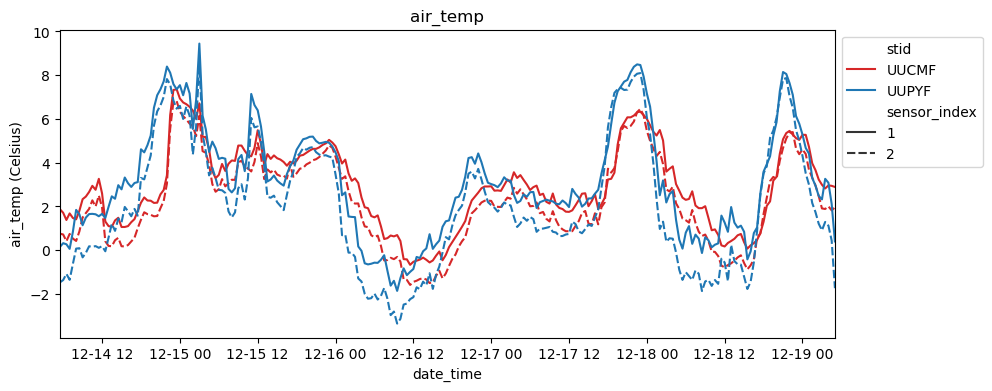

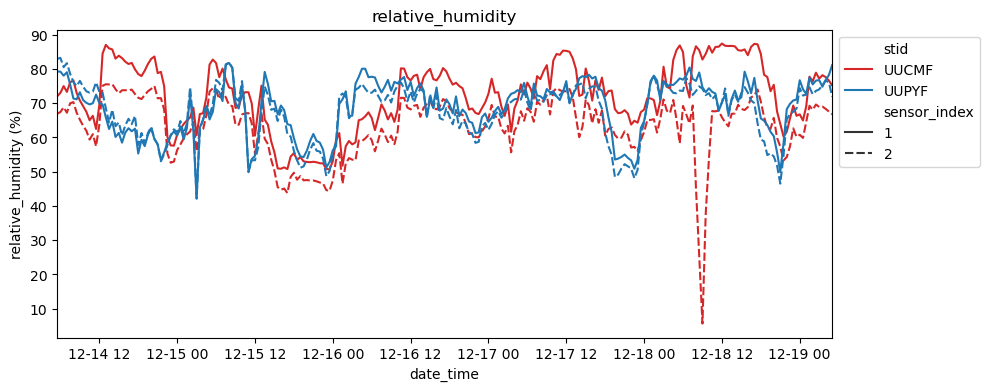

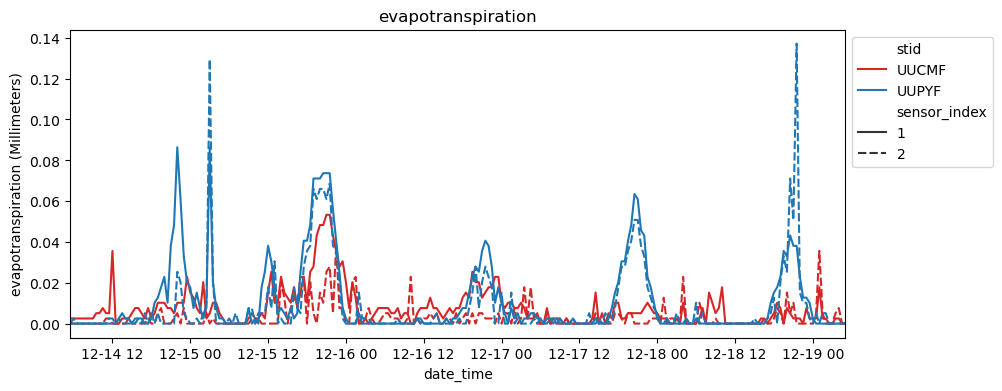

In [60]:
for var in ["air_temp", "relative_humidity", "evapotranspiration"]:
    plt.figure(figsize=(10, 4))

    _df = df.filter(variable=var)

    ax = sns.lineplot(
        _df,
        x="date_time",
        y="value",
        hue="stid",
        style="sensor_index",
        palette={"UUPYF": "tab:blue", "UUCMF": "tab:red"},
    )

    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_xlim(df["date_time"].min(), df["date_time"].max())
    ax.set_title(var)
    ax.set_ylabel(f'{var} ({_df['units'][0]})')


I don't actually know if sensor_index 1 or 2 is the EC150 or the LI170. I would have to ask the station owners which is which since the Synoptic API doesn't tell me. 

Ok, I visually checked with MesoWest which sensor_index is which sensor
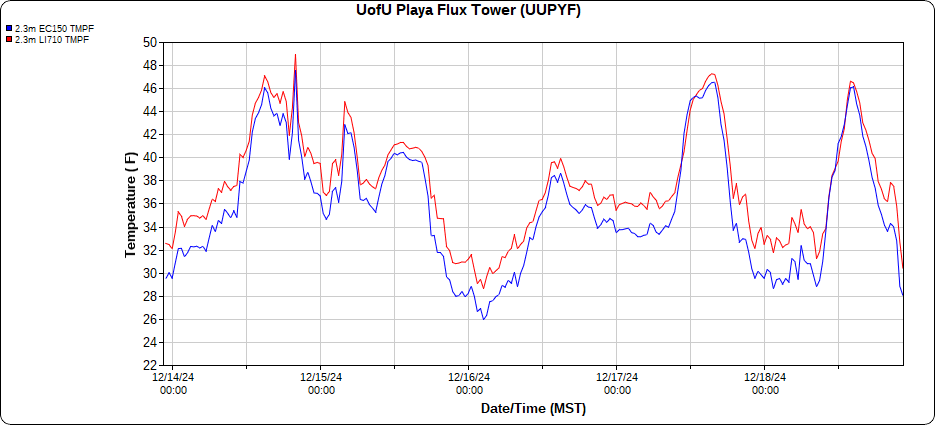

Now I can easily create a new column "sensor_name" using Polars...

In [53]:
a = df.with_columns(
    sensor_name=pl.col("sensor_index")
    .replace_strict({2: "EC150", 1: "LI170"})
    .alias("sensor_index")
)

Text(0.5, 1.0, 'air_temp')

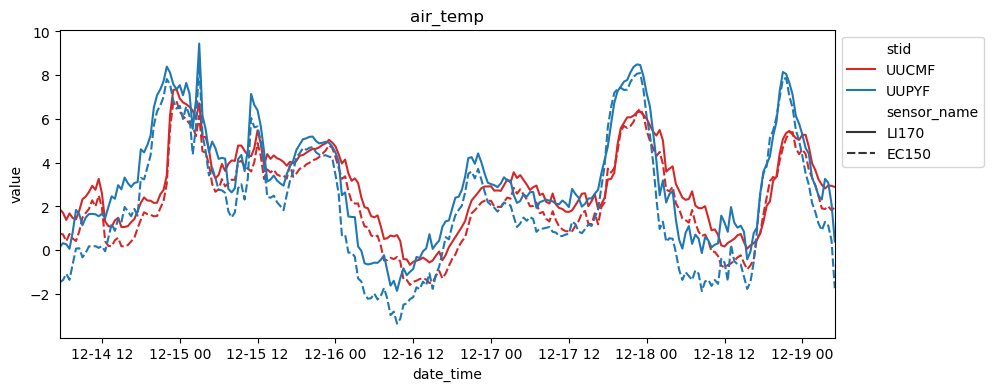

In [55]:
plt.figure(figsize=(10, 4))

var = "air_temp"

ax = sns.lineplot(
    a.filter(variable=var),
    x="date_time",
    y="value",
    hue="stid",
    style="sensor_name",
    palette={"UUPYF": "tab:blue", "UUCMF": "tab:red"},
)

ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlim(df["date_time"].min(), df["date_time"].max())
ax.set_title(f"{var}")
